In [2]:
from fastai.vision.all import *
import os
from fastcore import *
from fastbook import *
from fastai.vision.widgets import ImageClassifierCleaner


In [3]:
urls = search_images_ddg('write off cars', max_images=1)
len(urls), urls[0]

(1,
 'https://c8.alamy.com/comp/2BKKJFG/scrap-metal-car-insurance-write-off-car-crash-2BKKJFG.jpg')

In [3]:
dest = Path('example.jpg')
if not dest.exists(): download_url(urls[0],dest,show_progress=False)

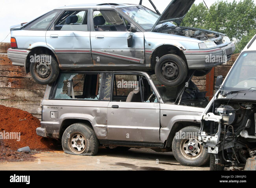

In [4]:
im = Image.open(dest)
im.to_thumb(256,256)


In [7]:
searches = ['scatched or dented cars','write off cars']
path = Path('writeoff_or_not')

if not path.exists():
    path.mkdir(parents=True)

for o in searches:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} photo')
        download_images(dest, urls=results[:200])
        resize_image(dest, max_size=400, dest=dest)

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

(#15) [None,None,None,None,None,None,None,None,None,None...]

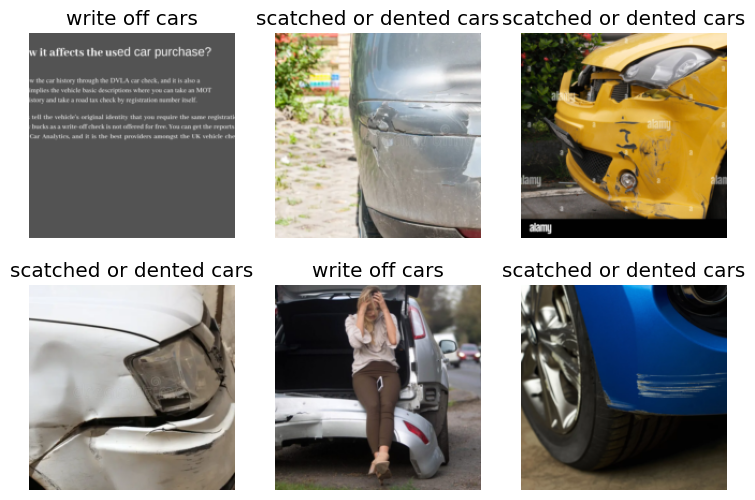

In [9]:
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock ),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(192)
).dataloaders(path)

dls.show_batch(max_n=6)

In [10]:
learn = cnn_learner(dls, resnet18, metrics= error_rate)
learn.fine_tune(3)

c:\My Drive\ML projects\write-off_car\myenv\Lib\site-packages\fastai\vision\learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,1.000473,0.622192,0.209790,00:39


epoch,train_loss,valid_loss,error_rate,time
0,0.461490,0.407128,0.153846,00:46
1,0.359027,0.300423,0.083916,00:45
2,0.274851,0.270171,0.069930,00:45


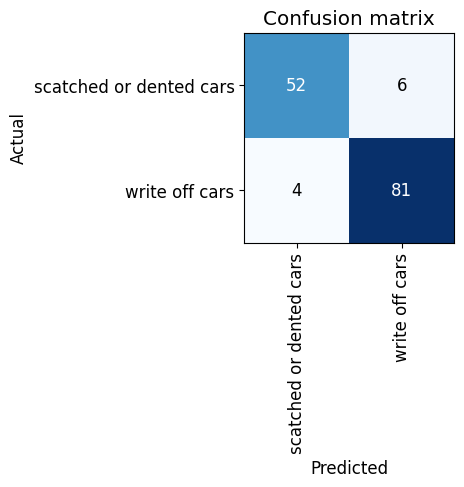

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

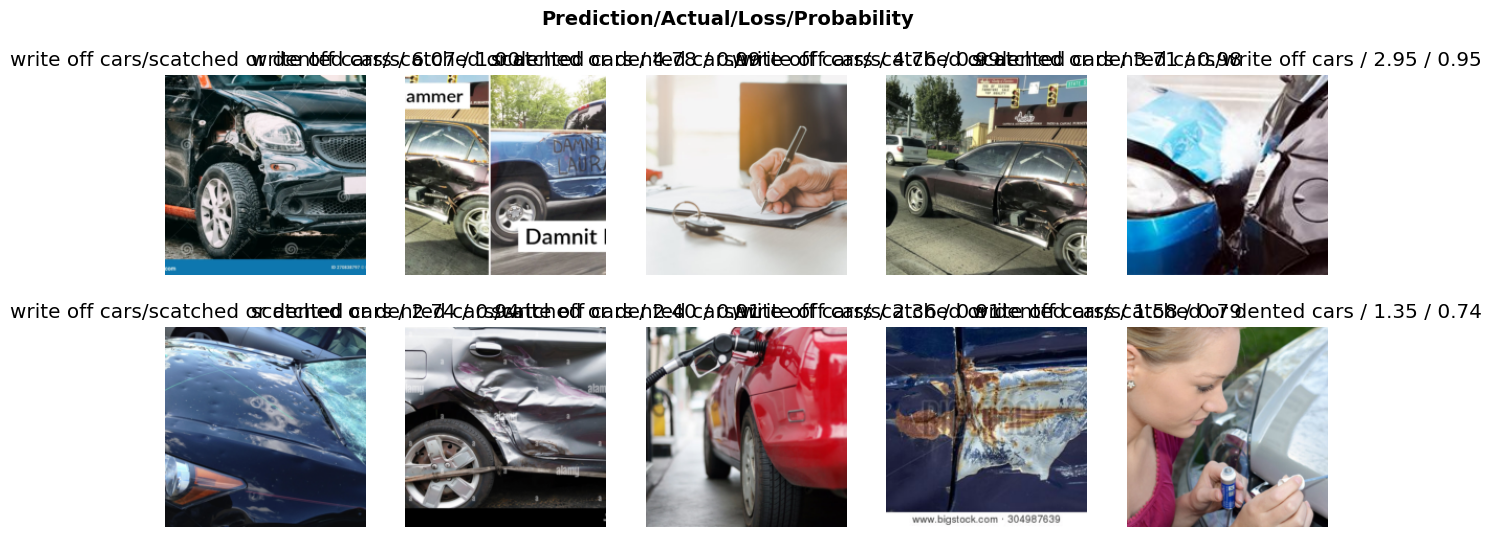

In [12]:
interp.plot_top_losses(10, nrows =2)

In [13]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [15]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'writeoff_or_not\\write off cars\\4ff04ffd-e58d-4729-93f6-9d54145f79c5.png'

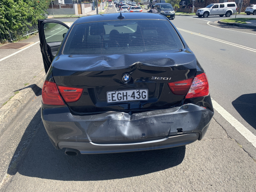

In [16]:
dest_test = Path('test.jpg')
im2 = Image.open(dest_test)
im2.to_thumb(256,256)

In [17]:
is_writeoff,_,probs = learn.predict(PILImage.create('test.jpg'))
print(f"This is a: {is_writeoff}.")
print(f"Probability it's not a write off car: {probs[0]:.4f}")

This is a: write off cars.
Probability it's not a write off car: 0.0143


In [18]:
learn.export('model.pkl')